In [1]:
import glacierml as gl
from tqdm import tqdm
import scipy.stats as st
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

2023-11-06 15:33:27.084713: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-06 15:33:27.305670: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-06 15:33:28.303207: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#### models trained on data sorted by select feature ####
# feat = 'Area'
# feat = 'Thickness'
feat = 'none'
# feat = 'shuffle'

#### if sorted, ascending or descending ####
# asc = True
# asc = False
asc = 'none'


#### normalize data for plotting ####
norm = True

def normx(x, norm = True):
    if norm == False:
        z = x
    elif norm == True:
        z = (x - np.min(x)) / (np.max(x) - np.min(x)) * 100
    return z

In [3]:
df = gl.coregister_data('4')
if feat == 'none' and asc == 'none':
    a = 'none'
    order = 'none'
    df = df.reset_index().drop('index',axis = 1)
elif feat != 'none' and asc == True:
    a = 'ascending'
    order = 'ascending'
    df = df.sort_values(feat,ascending = asc).reset_index().drop('index',axis = 1)
elif feat != 'none' and asc == False:
    a = 'descending'
    order = 'descending'
    df = df.sort_values(feat,ascending = asc).reset_index().drop('index',axis = 1)
elif feat == 'shuffle' and asc == 'none':
    df = df.sample(frac = 1,random_state = 0)
    df = df.reset_index().drop('index', axis = 1)
    a = 'none'
    order = 'none'

#### Add mean thickness estimates to dataset ####
# model_path = '/data/fast1/glacierml/models/LOO/'
model_path = os.path.join(
    '/data/fast1/glacierml/models/LOO/', feat, order ,'rgi_est_raw.pkl'
)
# RGI = pd.read_pickle(model_path + 'rgi_est_raw.pkl') ascendingThickness_rgi_est_raw_.pkl
RGI = pd.read_pickle(model_path) 
rgi_list = list(df)[:-1]
rgi_list.append('RGIId')
old_index = df.index.to_list()
df = pd.merge(df,RGI,how = 'inner', on = rgi_list)

#### Add Farinotti mean thickness estimates ####
ref_pth = '/data/fast1/glacierml/data/reference_thicknesses/'
ref = pd.DataFrame()
for file in os.listdir(ref_pth):
    if 'Farinotti' in file:
        file_reader = pd.read_csv('reference_thicknesses/' + file)
        ref = pd.concat([ref, file_reader], ignore_index = True) 
ref = ref.rename(columns = {
     'Farinotti Mean Thickness':'FMT',
})
ref = ref[[
     'FMT',
     'RGIId',
]]

df = pd.merge(df, ref, how = 'inner', on = 'RGIId')
df

,RGIId,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax,Thickness,GLIMSId,BgnDate,EndDate,O1Region,O2Region,Status,Connect,Form,TermType,Surging,Linkages,Name,region,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,FMT
0,RGI60-07.01132,78.128100,15.626700,12.8,332,583,970,3.463,351,4254,67.0,G015627E78128N,20030712,-9999999,7,1,0,0,0,0,0,1,Bogerbreen,07,69.901192,64.268013,68.565765,68.488373,68.609436,68.807426,68.239105,64.697083,68.116508,67.411873,68.162827,69.558601,68.791016,69.022514,68.673531,69.272888,69.764946,68.044479,69.370621,67.363327,71.734581,68.481308,69.948265,68.555702,69.440369,67.551079,71.579453,70.765503,71.078712,67.273026,69.112991,66.126808,68.949898,66.467567,70.849335,67.412758,70.574936,68.502319,67.458130,68.144920,69.240166,69.340195,71.306770,70.814667,67.815117,70.979553,67.146156,69.487831,68.541733,69.777733,67.761963,67.474083,69.831268,67.299759,67.051941,69.910141,67.952408,70.280052,69.224342,69.694565,66.439896,66.711281,68.818886,69.164627,70.573006,71.965134,72.363724,70.949509,67.875671,68.203003,69.290985,71.200966,69.093552,69.750847,70.073509,70.870773,68.699905,71.902145,69.366333,67.845932,68.804703,68.235321,68.071777,67.143227,64.307434,68.069237,65.229408,65.924339,67.822296,65.588295,65.948692,67.419495,64.925858,72.704208,64.929031,65.328590,65.915306,66.198700,66.508057,66.883667,68.076698,63.752808,65.783264,66.576233,63.582699,66.773911,66.155174,69.366486,65.524025,65.351120,66.086967,66.276459,66.664246,67.846298,61.399197,66.192490,69.020264,68.437538,68.014816,70.120224,65.610535,64.159996,67.090958,65.838249,67.486542,70.234215,67.008965,64.250778,71.441574,69.877869,69.209282,67.993279,66.840935,66.526711,63.538177,68.155869,67.871452,66.955215,66.724670,68.218201,67.508987,67.278328,67.627937,67.364288,68.648003,67.838577,66.892799,66.930939,63.886765,67.864784,65.939537,66.511253,65.275772,69.919373,66.417374,68.403168,67.510567,69.132103,66.012772,69.957947,67.678116,68.192009,69.594322,69.061714,70.130699,68.570351,68.653618,68.389694,67.753082,68.559547,68.246544,68.150787,67.482330,70.311737,67.447044,67.883133,64.468552,68.123306,69.736603,68.073578,69.274658,70.425774,67.846626,69.837051,68.385559,64.385406,66.766144,66.565544,68.081970,64.234566,65.891418,65.825607,65.518883,68.976341,66.212273,61.077885,66.115196,65.007729,66.013512,68.124794,67.869003,68.797989,67.678459,61.471828,66.295883,65.886513,66.541191,72.403671,72.073814,66.954590,65.737328,65.210976,63.135563,65.732750,69.033714,64.789162,65.329124,70.639099,67.310555,65.370895,65.400658,67.184792,64.642639,66.007240,63.528191,67.084465,67.331047,67.791451,67.362061,67.056503,66.663994,67.232597,65.979897,64.076019,62.380604,65.602737,65.299248,65.700706,70.664833,68.737503,66.108574,67.046364,67.260941,67.387

In [4]:
cols = []
for i in range(341):
    cols.append(i)
# cols = old_index

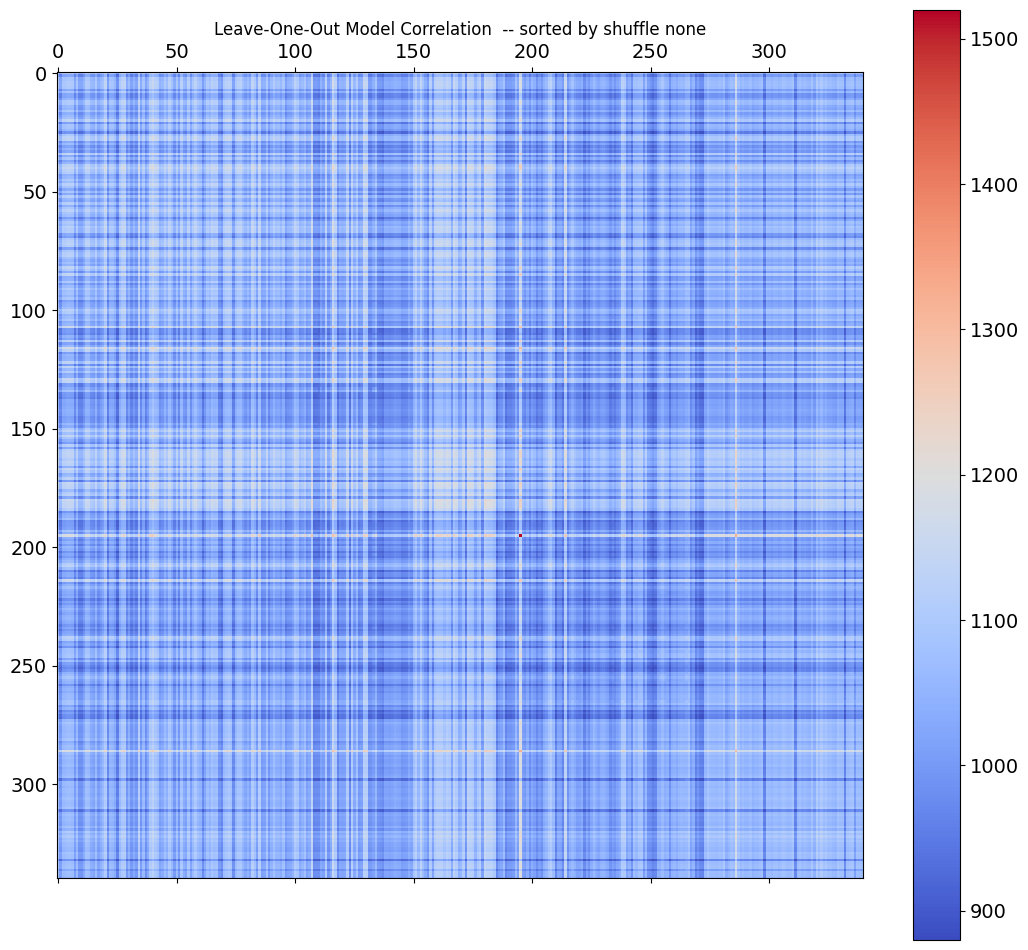

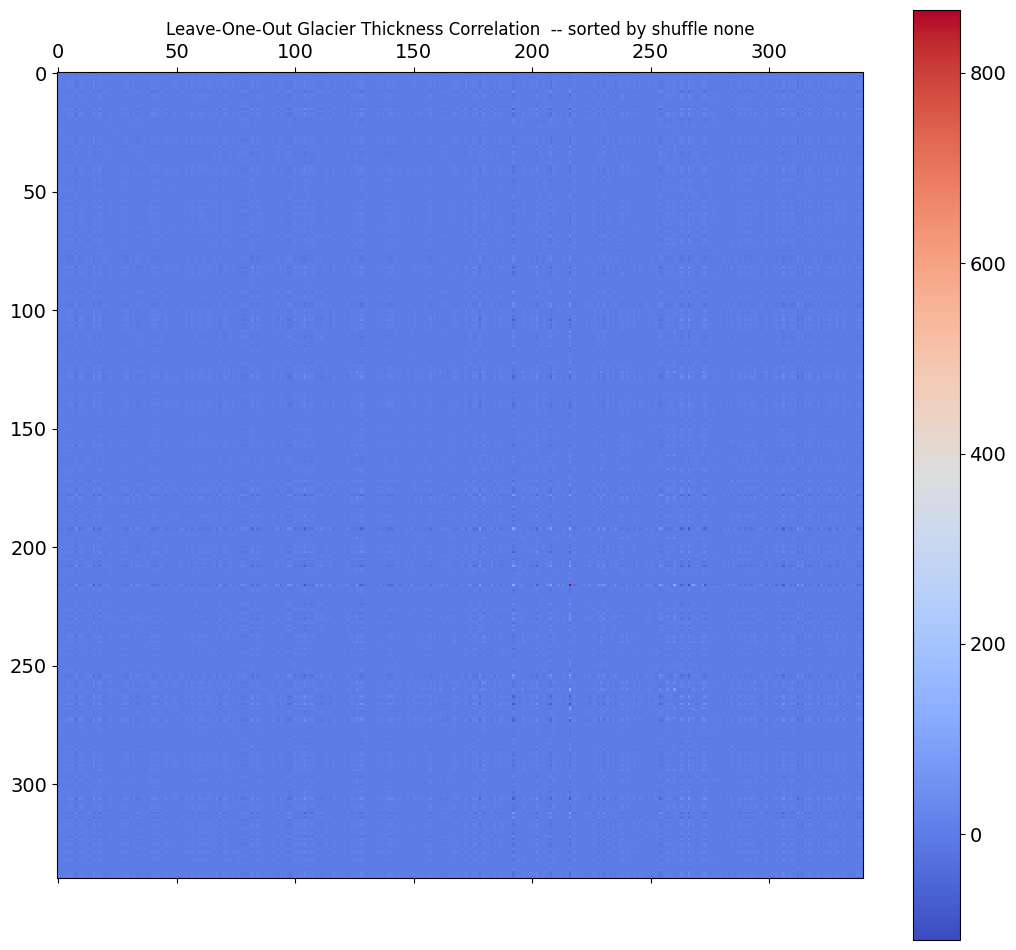

In [138]:
#Each row of m represents a variable
#each column a single observation of all those variables.

#treat each model as a variable
cov1 = np.cov(df[cols].T)
cor1 = np.corrcoef(df[cols].T)
f = plt.figure(figsize=(13, 12))
plt.matshow(
    cov1, fignum=f.number,cmap = 'coolwarm',vmin=np.min(cov1),vmax=np.max(cov1)
)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Leave-One-Out Model Correlation  -- sorted by ' + feat + ' ' +  order)

plt.show()

#treat each glacier as a variable
cov2 = np.cov(df[cols])
cor2 = np.corrcoef(df[cols])
f = plt.figure(figsize=(13, 12))
plt.matshow(
    cov2, fignum=f.number,cmap = 'coolwarm',vmin=np.min(cov2),vmax=np.max(cov2)
)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Leave-One-Out Glacier Thickness Correlation  -- sorted by ' + feat + ' ' +  order)

plt.show()

In [72]:
from scipy.sparse.linalg import eigs

In [133]:
L,Q=eigs(cov,10)

[0.51856665+0.j 0.23628111+0.j 0.12367515+0.j 0.05053053+0.j
 0.02014786+0.j 0.01618767+0.j 0.0135068 +0.j 0.00982521+0.j
 0.00693808+0.j 0.00434094+0.j]


/home/sa42/miniconda3/envs/new_kernel/lib/python3.8/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/sa42/miniconda3/envs/new_kernel/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6793: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


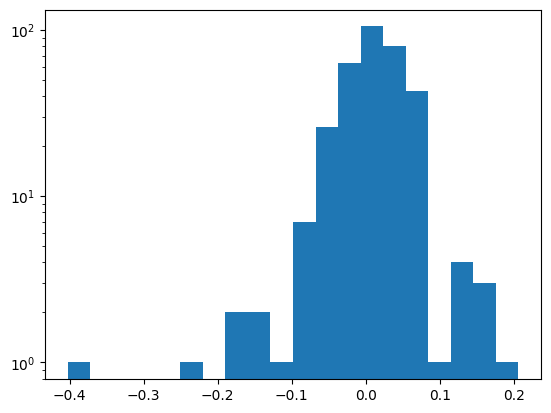

In [89]:
print(L/sum(L))

plt.hist((Q[:,0]),20)
plt.yscale('log')



In [94]:
sum(np.abs(Q[:,0]) > 0.01)/340

0.7764705882352941

(0.0, 10.0)

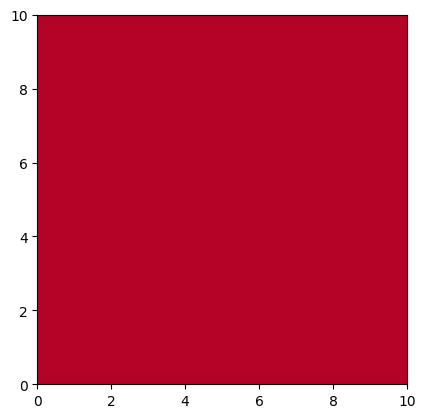

In [132]:
plt.imshow(cov1,vmin=-10,vmax=10,cmap='coolwarm')
plt.xlim([0,10])
plt.ylim([0,10])

In [97]:
thickness_estimates = df[cols].T.to_numpy()
thickness_estimates.shape

(340, 340)

In [105]:
df

,RGIId,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax,Thickness,GLIMSId,BgnDate,EndDate,O1Region,O2Region,Status,Connect,Form,TermType,Surging,Linkages,Name,region,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,FMT,LCI,UCI,res
0,RGI60-07.01132,78.128100,15.626700,12.8,332,583,970,3.463,351,4254,67.0,G015627E78128N,20030712,-9999999,7,1,0,0,0,0,0,1,Bogerbreen,07,69.901192,64.268013,68.565765,68.488373,68.609436,68.807426,68.239105,64.697083,68.116508,67.411873,68.162827,69.558601,68.791016,69.022514,68.673531,69.272888,69.764946,68.044479,69.370621,67.363327,71.734581,68.481308,69.948265,68.555702,69.440369,67.551079,71.579453,70.765503,71.078712,67.273026,69.112991,66.126808,68.949898,66.467567,70.849335,67.412758,70.574936,68.502319,67.458130,68.144920,69.240166,69.340195,71.306770,70.814667,67.815117,70.979553,67.146156,69.487831,68.541733,69.777733,67.761963,67.474083,69.831268,67.299759,67.051941,69.910141,67.952408,70.280052,69.224342,69.694565,66.439896,66.711281,68.818886,69.164627,70.573006,71.965134,72.363724,70.949509,67.875671,68.203003,69.290985,71.200966,69.093552,69.750847,70.073509,70.870773,68.699905,71.902145,69.366333,67.845932,68.804703,68.235321,68.071777,67.143227,64.307434,68.069237,65.229408,65.924339,67.822296,65.588295,65.948692,67.419495,64.925858,72.704208,64.929031,65.328590,65.915306,66.198700,66.508057,66.883667,68.076698,63.752808,65.783264,66.576233,63.582699,66.773911,66.155174,69.366486,65.524025,65.351120,66.086967,66.276459,66.664246,67.846298,61.399197,66.192490,69.020264,68.437538,68.014816,70.120224,65.610535,64.159996,67.090958,65.838249,67.486542,70.234215,67.008965,64.250778,71.441574,69.877869,69.209282,67.993279,66.840935,66.526711,63.538177,68.155869,67.871452,66.955215,66.724670,68.218201,67.508987,67.278328,67.627937,67.364288,68.648003,67.838577,66.892799,66.930939,63.886765,67.864784,65.939537,66.511253,65.275772,69.919373,66.417374,68.403168,67.510567,69.132103,66.012772,69.957947,67.678116,68.192009,69.594322,69.061714,70.130699,68.570351,68.653618,68.389694,67.753082,68.559547,68.246544,68.150787,67.482330,70.311737,67.447044,67.883133,64.468552,68.123306,69.736603,68.073578,69.274658,70.425774,67.846626,69.837051,68.385559,64.385406,66.766144,66.565544,68.081970,64.234566,65.891418,65.825607,65.518883,68.976341,66.212273,61.077885,66.115196,65.007729,66.013512,68.124794,67.869003,68.797989,67.678459,61.471828,66.295883,65.886513,66.541191,72.403671,72.073814,66.954590,65.737328,65.210976,63.135563,65.732750,69.033714,64.789162,65.329124,70.639099,67.310555,65.370895,65.400658,67.184792,64.642639,66.007240,63.528191,67.084465,67.331047,67.791451,67.362061,67.056503,66.663994,67.232597,65.979897,64.076019,62.380604,65.602737,65.299248,65.700706,70.664833,68.737503,66.108574,67.046364,67.2

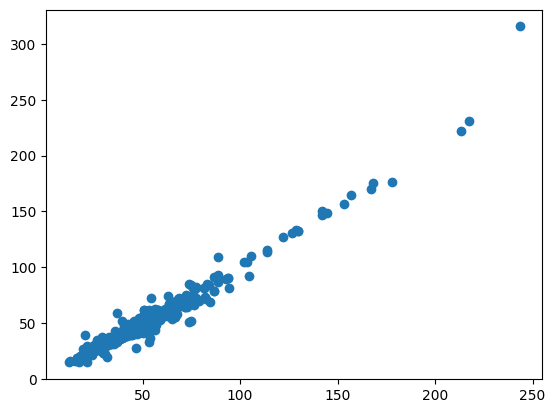

In [131]:
plt.scatter(df[213],df[333])

(1.1428780555725098, 270.5263819694519, 1.6591140747070305, 271.0426179885864)

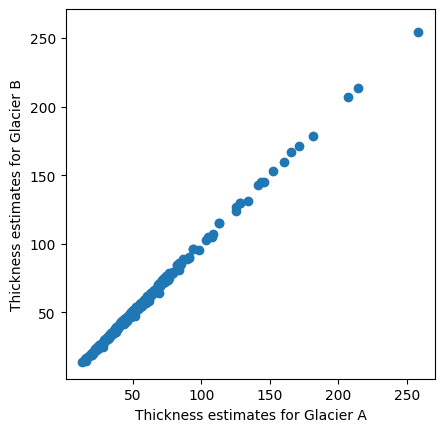

In [136]:
plt.plot(thickness_estimates[10,:],thickness_estimates[9,:],'o')
plt.xlabel('Thickness estimates for Glacier A')
plt.ylabel('Thickness estimates for Glacier B')
plt.axis('square')

Text(0.5, 1.0, 'Leave-One-Out X-val 95% CI')

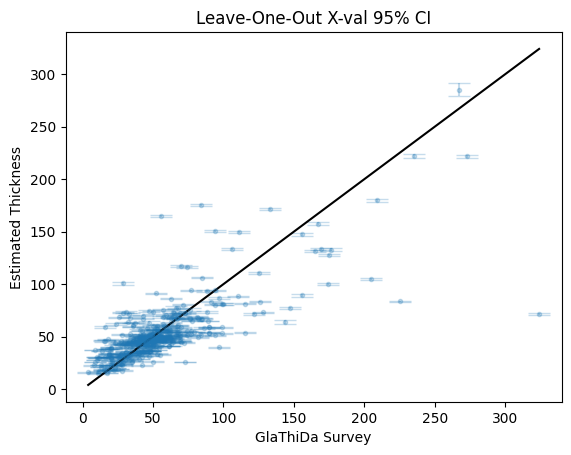

In [20]:
#### Calculate 95% confidence intervals ####
X = np.mean(df[cols], axis = 1)
se = np.std(df[cols], axis = 1) / np.sqrt(len(cols))

df['LCI'] = X - (1.96 * se)
df['UCI'] = X + (1.96 * se)

lb = df['LCI'] / 1e3 * df['Area'] / 1e3
ub = df['UCI'] / 1e3 * df['Area'] / 1e3

x = df['Thickness']
# y = np.mean(dfci, axis = 1)
# y = df['we']
y = np.mean(df[cols],axis = 1)
plt.errorbar(
    x,y,yerr = df['UCI'] - df['LCI'],
        alpha = 0.25,
#     label = 'Estimates $\hat{\mu}(x)$',
    linestyle = 'None',
    marker = '.',
    capsize = 8,
    color = '#1f77b4',
)

plt.plot(
    (x.min(),x.max()),
    (x.min(),x.max()),
    '-k'
)

plt.ylabel('Estimated Thickness')
plt.xlabel('GlaThiDa Survey')
plt.title('Leave-One-Out X-val 95% CI')
# plt.xscale('log')
# plt.yscale('log')

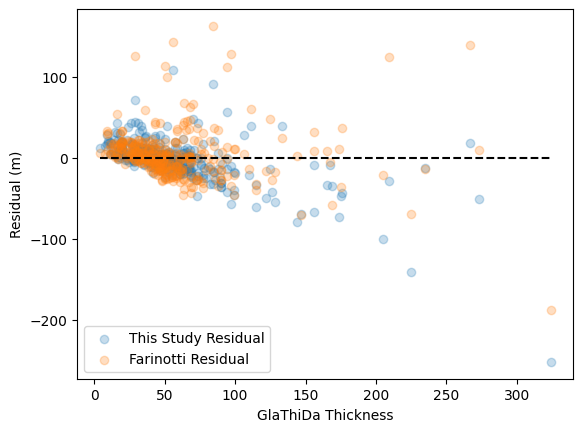

In [21]:
plt.scatter(
    x,(y-x),alpha = 0.25,label = 'This Study Residual'
)
plt.scatter(
    x,(df['FMT']-x),alpha = 0.25,label = 'Farinotti Residual'
)
plt.plot(
    (x.min(),x.max()),
    (0,0),'k--'
)
plt.xlabel('GlaThiDa Thickness')
plt.ylabel('Residual (m)')
plt.legend()

In [24]:
np.std(y-x)

26.952153311307768

In [25]:
np.std((df['FMT']-x))

30.77324437120514

In [8]:
df['res'] = y - df['Thickness'] 

df[abs(df['res']) >= 100]

/tmp/ipykernel_2219036/3340318367.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['res'] = y - df['Thickness']


,RGIId,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax,Thickness,GLIMSId,BgnDate,EndDate,O1Region,O2Region,Status,Connect,Form,TermType,Surging,Linkages,Name,region,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,FMT,LCI,UCI,res
196,RGI60-07.01481,78.7872,13.1481,7.4,73,581,1015,108.297,285,24201,56.0,G013148E78787N,20070901,-9999999,7,1,0,0,0,0,3,1,Kongsvegen,07,171.133057,157.584229,167.249863,165.638870,168.456604,166.629013,167.914047,158.071854,169.020615,159.261612,160.140137,163.967926,167.357468,168.202423,164.239120,164.642929,168.717270,162.328156,165.162399,164.625305,174.462540,159.839066,164.887878,168.543823,163.467957,156.664169,170.780975,172.372131,172.130753,160.223419,162.973846,158.436768,162.639038,159.999100,171.488541,159.747360,169.153488,159.359756,164.470856,168.743759,171.103500,172.162399,172.314713,164.418732,165.338547,171.072083,165.593491,171.852402,166.705444,164.665192,168.126740,160.296158,171.999985,162.312943,161.665680,170.691589,161.776138,170.277924,172.194443,168.788391,163.828491,157.784256,162.026047,167.907227,167.032974,174.049362,171.798615,172.731430,160.483170,160.412994,169.853821,173.746735,170.487625,170.446411,159.134903,170.112320,170.681885,173.300537,167.251099,161.826126,166.122025,162.746811,172.133896,169.695419,159.226425,171.804031,160.169052,161.072708,168.535995,158.970947,163.320862,169.363907,165.866302,168.914368,162.740509,166.162888,162.622192,161.711182,161.781738,164.732269,169.178543,170.200378,160.477509,160.292404,161.262741,160.744812,161.178802,173.342270,155.946503,157.856461,160.913528,162.364502,162.210693,168.721359,151.879501,163.445969,174.641541,168.321121,159.400482,166.319916,161.530060,161.819977,168.971863,156.152771,171.805603,166.994812,166.720963,157.822861,162.340103,172.927383,173.627304,162.708618,163.437546,158.596039,158.682114,163.285309,161.684845,160.882416,164.666199,166.757874,164.050629,165.429138,167.520279,166.338501,166.290421,163.438400,163.172485,163.867126,160.405380,164.835068,169.117599,173.388840,165.009750,174.091141,164.669052,167.024429,163.301468,171.403214,164.238464,173.041550,173.332611,173.388489,173.147202,170.389465,172.402084,173.414749,166.771057,174.582397,173.018051,167.825943,169.738281,174.201797,162.731827,174.692490,172.732407,172.615891,165.609573,171.218781,174.038147,163.945831,175.776154,176.071625,174.176880,173.986420,173.626251,159.608353,165.944977,165.824585,168.526489,159.599884,161.390259,162.357468,162.906616,169.837463,162.543671,146.328583,161.899933,158.462860,163.586014,161.222977,164.457108,162.588821,157.946442,157.162918,158.884598,162.223816,165.092178,171.614670,172.436829,167.391220,158.360550,162.821625,159.903702,156.719208,174.174347,158.753189,164.530197,169.926041,163.839508,162.071655,161.

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,
          1.,   3.,   5.,   9.,  21.,  73., 134.,  60.,  17.,  11.,   1.,
          1.,   1.,   1.]),
 array([-252.23583221, -237.80301636, -223.3702005 , -208.93738464,
        -194.50456879, -180.07175293, -165.63893707, -151.20612122,
        -136.77330536, -122.3404895 , -107.90767365,  -93.47485779,
         -79.04204193,  -64.60922607,  -50.17641022,  -35.74359436,
         -21.3107785 ,   -6.87796265,    7.55485321,   21.98766907,
          36.42048492,   50.85330078,   65.28611664,   79.7189325 ,
          94.15174835,  108.58456421]),
 <BarContainer object of 25 artists>)

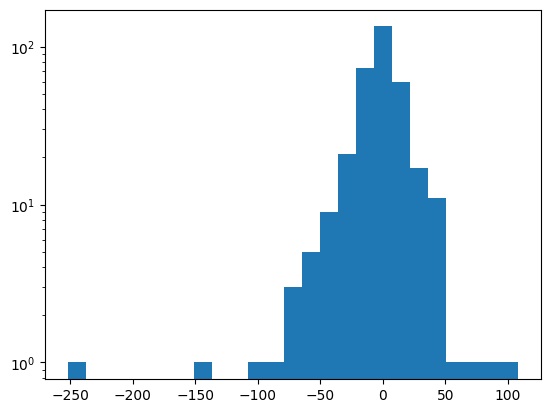

In [9]:
plt.hist(y-x,bins = 25,log = True)

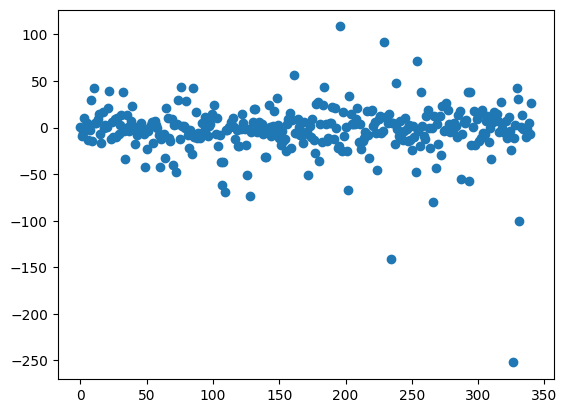

In [10]:
plt.scatter(
    df.index, df['res']
)
# plt.xscale('log')

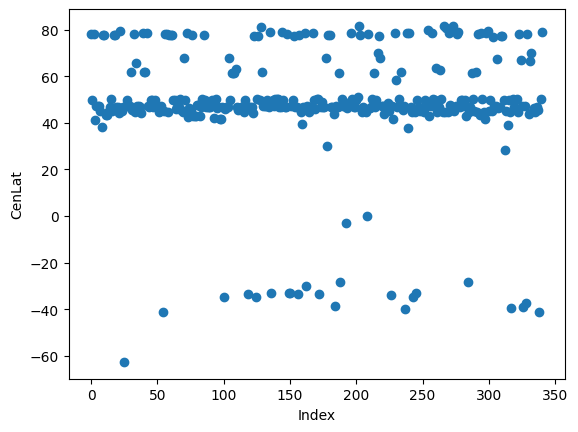

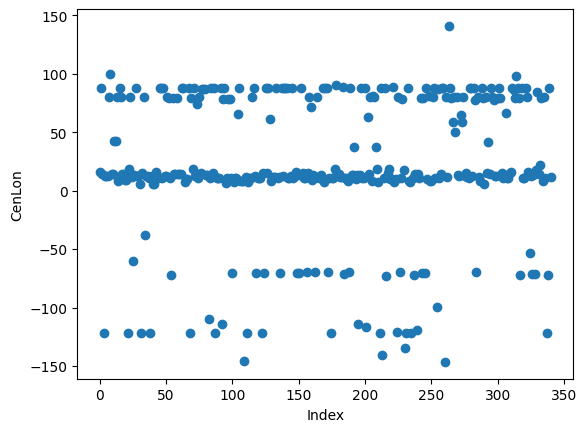

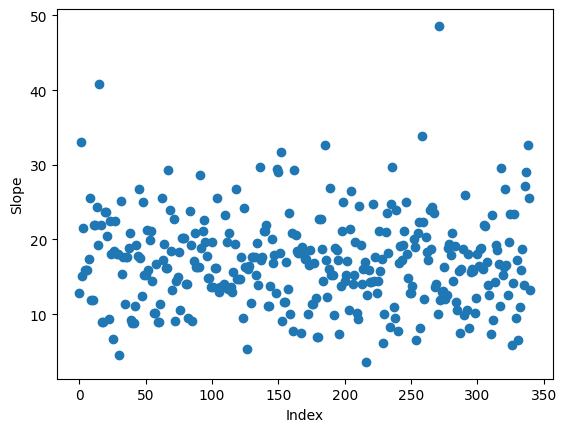

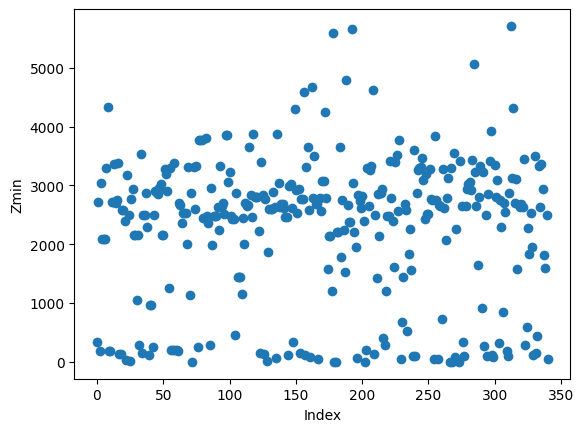

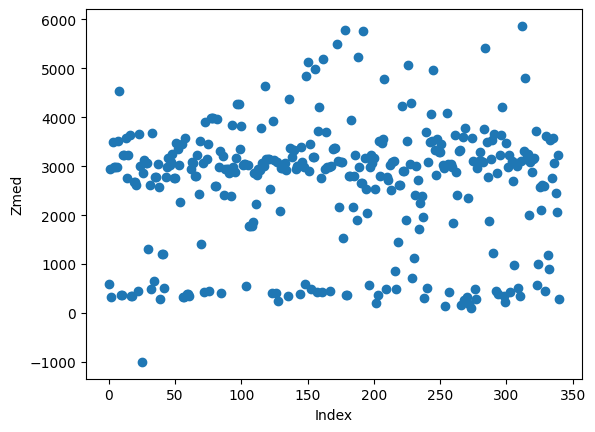

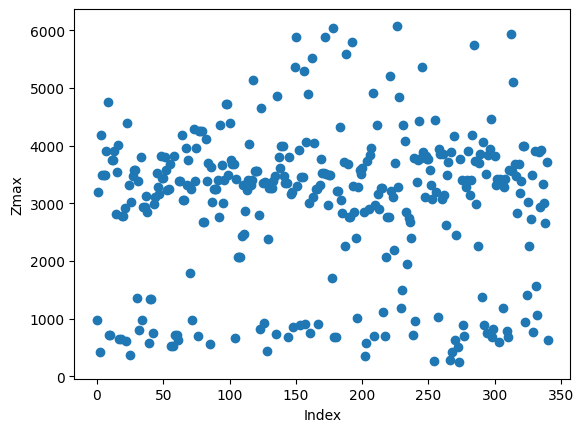

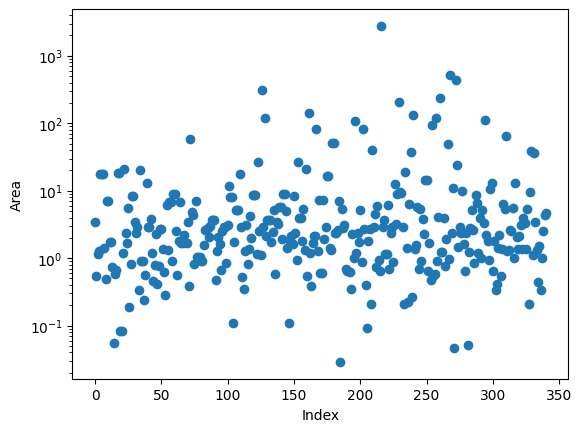

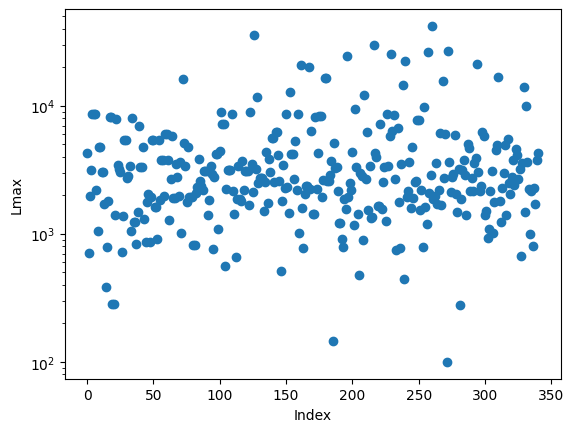

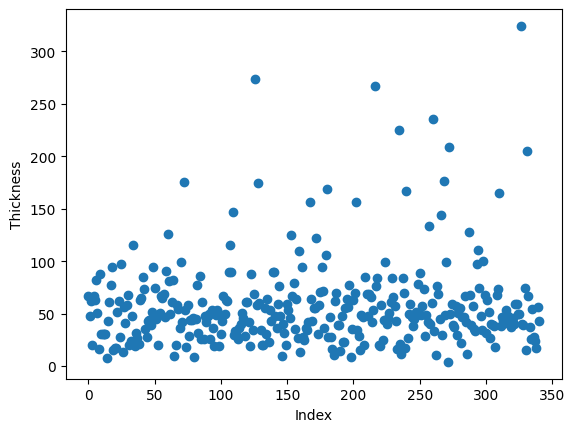

In [11]:
feat_list = ['CenLat', 'CenLon','Slope','Zmin','Zmed','Zmax','Area','Lmax','Thickness']

for feature in feat_list:
    plt.scatter(
        df.index,
        df[feature]
    )
    plt.xlabel('Index')
    plt.ylabel(feature)
    if feature == 'Area' or feature == 'Lmax':
        plt.yscale('log')
    plt.show()



In [12]:
cov = pd.DataFrame(cov)
# cor = pd.DataFrame(cor)

# bad_indexes = cov[cov[cols] == 0].dropna(axis = 0).index
# cov_d = cov.drop(bad_indexes)
# cor_d = cor.drop(bad_indexes)

# cov_d = cov_d.reset_index().drop('index',axis = 1)
# cor_d = cor_d.reset_index().drop('index',axis = 1)

# dftr = dft.drop(bad_indexes)
# dftr = dftr.reset_index().drop('index',axis = 1)

# dfpd = df[cols].T.copy()
# dfpd = dfpd.drop(bad_indexes)
# dfpd = dfpd.reset_index().drop('index', axis = 1)

In [13]:
# identify columns that have one estimate for all glaciers.
bad_models = df[cols].T[df.T.duplicated()].index
bad_models

/tmp/ipykernel_2219036/1117204460.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bad_models = df[cols].T[df.T.duplicated()].index


Index([337], dtype='object')

In [14]:
cols = list(filter(lambda a: a not in bad_models.to_list(), cols))
df = df.drop(bad_models)

100%|██████████| 340/340 [00:06<00:00, 49.00it/s]


<Axes: ylabel='Left-Out Index'>

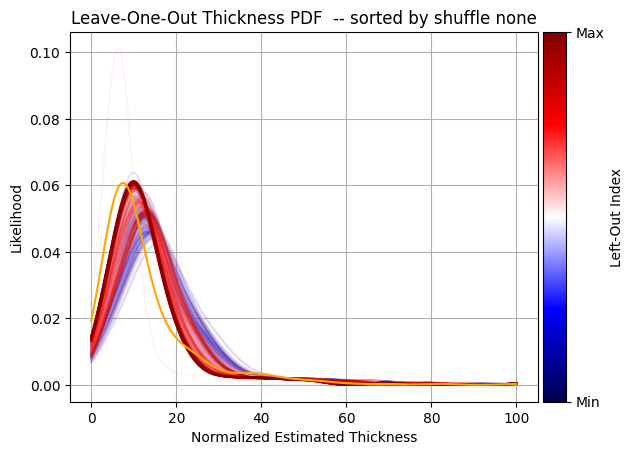

In [15]:
n = 0
p = plt.get_cmap('seismic')
for i in tqdm(
    df.index,
):
    x = df[cols].T.loc[i]
    z = normx(x,norm)
    x_eval = np.linspace(z.min(),z.max(),500)

    kde = st.gaussian_kde(np.array(z))
    plt.plot(
        x_eval, kde(x_eval), '-',alpha = 0.15,
        c = p(n/(len(df) - 1))
    )
    n = n + 1
x = df['FMT']
z = normx(x,norm)
x_eval = np.linspace(z.min(),z.max(),500)
kde = st.gaussian_kde(np.array(z))
plt.plot(
    x_eval, kde(x_eval), '-',alpha = 1,
    c = 'orange'
)
plt.grid()

# plt.xscale('symlog')
plt.ylabel('Likelihood')
if norm == True:
    plt.xlabel('Normalized Estimated Thickness')
if norm == False:
    plt.xlabel('Estimated Thickness')
plt.title('Leave-One-Out Thickness PDF  -- sorted by ' + feat + ' ' +  order)
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = mpl.colorbar.ColorbarBase(
    ax_cb, cmap=p, orientation='vertical',
    ticklocation = 'auto',ticks = [],
    label = 'Left-Out Index'
)
cb1.set_ticks(ticks = (0,1),labels = ['Min','Max'])
# cb1.set_label('Thickness',x = -0.07)
plt.gcf().add_axes(ax_cb)
#     plt.show()


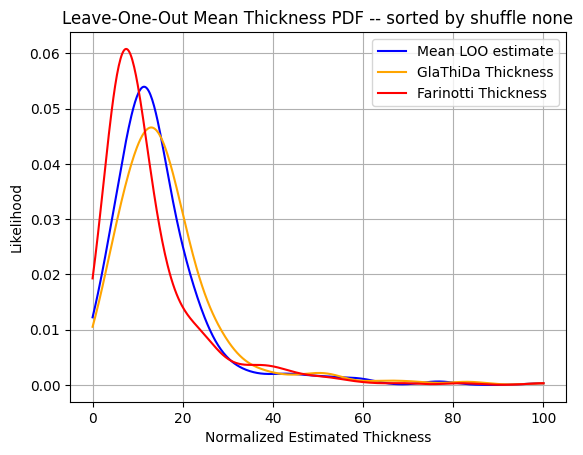

In [16]:
# check the mean estimate.

x = np.mean(df[cols],axis = 1)
z = normx(x,norm)
x_eval = np.linspace(z.min(),z.max(),500)
kde = st.gaussian_kde(np.array(z))
plt.plot(
    x_eval, kde(x_eval), '-',alpha = 1,
    c = 'blue',label = 'Mean LOO estimate'
)


x = df['Thickness']
z = normx(x,norm)
x_eval = np.linspace(z.min(),z.max(),500)
kde = st.gaussian_kde(np.array(z))
plt.plot(
    x_eval, kde(x_eval), '-',alpha = 1,
    c = 'orange',label = 'GlaThiDa Thickness'
)

x = df['FMT']
z = normx(x,norm)
x_eval = np.linspace(z.min(),z.max(),500)
kde = st.gaussian_kde(np.array(z))
plt.plot(
    x_eval, kde(x_eval), '-',alpha = 1,
    c = 'red',label = 'Farinotti Thickness'
)
plt.grid()
plt.legend()
plt.title('Leave-One-Out Mean Thickness PDF -- sorted by ' + feat + ' ' +  order)

# plt.xscale('symlog')
plt.ylabel('Likelihood')
if norm == True:
    plt.xlabel('Normalized Estimated Thickness')
if norm == False:
    plt.xlabel('Estimated Thickness')
# plt.title('Leave-One-Out Thickness PDF')
# divider = make_axes_locatable(plt.gca())
# ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
# cb1 = mpl.colorbar.ColorbarBase(
#     ax_cb, cmap=p, orientation='vertical',
#     ticklocation = 'auto',ticks = [],
#     label = 'Left-Out Thickness'
# )
# cb1.set_ticks(ticks = (0,1),labels = ['Min','Max'])
# cb1.set_label('Thickness',x = -0.07)
# plt.gcf().add_axes(ax_cb)

#     plt.show()
# plt.xscale('log')

Text(0, 0.5, 'Estimated Volume')

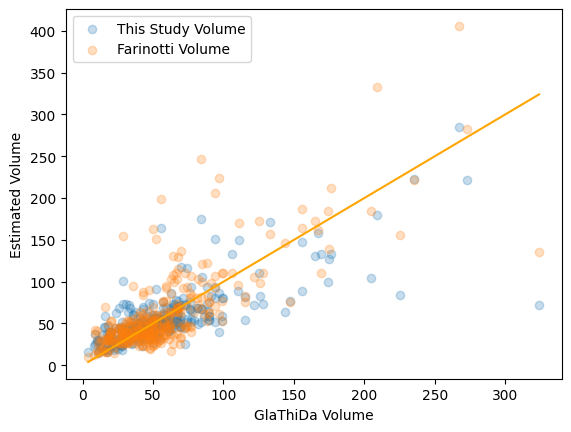

In [17]:
x = df['Thickness']
y = np.mean(df[cols],axis = 1)
z = df['FMT'] 
plt.scatter(
    x,y,alpha = 0.25,label = 'This Study Volume'
)
plt.scatter(
    x,z,alpha = 0.25,label = 'Farinotti Volume'
)
plt.plot(
    (x.min(),x.max()),
    (x.min(),x.max()),
    c = 'orange'    
)
plt.legend()
plt.xlabel('GlaThiDa Volume')
plt.ylabel('Estimated Volume')
# plt.xscale('log')
# plt.yscale('log')

100%|██████████| 340/340 [00:02<00:00, 128.79it/s]


<Axes: ylabel='Left-Out Index'>

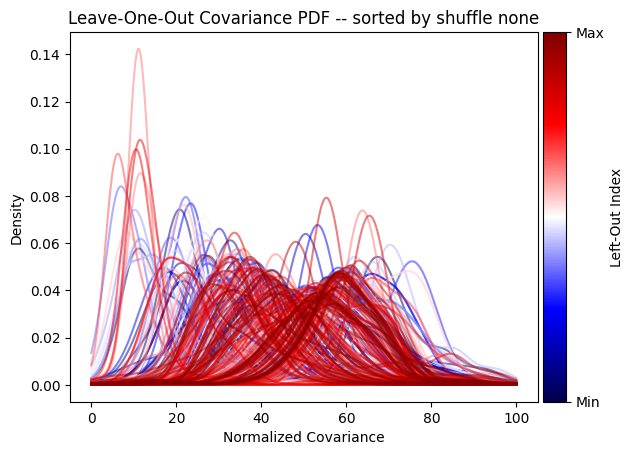

In [18]:
p = plt.get_cmap('seismic')
n = 0
for i in tqdm(
    df.index,
#     dftr.sort_values('Thickness',ascending = True).reset_index().index
):
#     print(dft['Thickness'].loc[i])

    
    x =cov.loc[i] 
    z = normx(x,norm)

    x_eval = np.linspace(z.min(),z.max(),500)

    kde = st.gaussian_kde(np.array(z))
    plt.plot(
        x_eval, kde(x_eval), '-',alpha = 0.5,
        c = p(n/(len(df)))
    )
    n = n + 1
#     c = p(n/(len(pos) - 1))
# plt.ylim(0,0.2)
# plt.yscale('log')
# plt.xscale('symlog')
plt.ylabel('Density')
if norm == True:
    plt.xlabel('Normalized Covariance')
if norm == False:
    plt.xlabel('Covariance')
plt.title('Leave-One-Out Covariance PDF -- sorted by ' + feat + ' ' +  order )
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = mpl.colorbar.ColorbarBase(
    ax_cb, cmap=p, orientation='vertical',
    ticklocation = 'auto',ticks = [],
    label = 'Left-Out Index'
)
cb1.set_ticks(ticks = (0,1),labels = ['Min','Max'])
# cb1.set_label('Thickness',x = -0.07)
plt.gcf().add_axes(ax_cb)

#     plt.show()
